# Exercise 5
Johannes Kammerer, Zhao Sun, Tong Yu

In [72]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.sparse import coo_matrix, csc_matrix, lil_matrix
from scipy.sparse.linalg import lsqr
import os

## Constructing the matrix X

In [378]:
def construct_X(M, alphas, Np = None):
    if Np == None:
        Np = int(np.ceil(math.sqrt(2) * M))
    if Np%2 == 0:
        Np = Np + 1 #Choosing an odd number of sensor elements
        
    X = lil_matrix((Np *len(alphas), M*M), dtype = np.float32) #create sparse matrix
    
    i = 0
    for alpha in alphas:
        rad = math.radians(alpha)
        rotation_matrix = np.array([[math.cos(rad), -math.sin(rad)],[math.sin(rad), math.cos(rad)]]) #rotation matrix
        
        for ja in range(M): #rotate all pixels
            for jb in range(M):
                center = np.array([(M-1)/2, (M-1)/2]) 
                coordinate = np.array([ja,jb]) - center #centalization
#                 coordinate = [ja, jb]
                x, y = np.dot(rotation_matrix, coordinate) #rotation corrdinate
                x = x + (Np-1)/2 #(decentalization) index on sensor
                bin_floor = np.floor(x)
                bin_ceil = np.ceil(x)
                
                if bin_ceil == bin_floor:
                    X[i*Np + bin_floor, jb*M + ja] = 1  #Xkm=1, ray fully hits pixel k=jb*M
#                     X[(jb-1)*M + (ja-1), (i-1)*Np + (bin_floor-1)] = 1
                else:
                    weight_floor = bin_ceil - x
                    weight_ceil = x - bin_floor
                
                    X[i*Np + bin_floor, jb*M + ja] = weight_floor
                    X[i*Np + bin_ceil, jb*M + ja]= weight_ceil
#                     X[(jb-1)*M + (ja-1), (i-1)*Np + (bin_floor-1)] = weight_floor
#                     X[(jb-1)*M + (ja-1), (i-1)*Np + (bin_ceil-1)] = weight_ceil
        i = i +1
    return X

In [379]:
X = construct_X(10, [-33,1,42]).todense() #Convert to a sense np.array to visualize

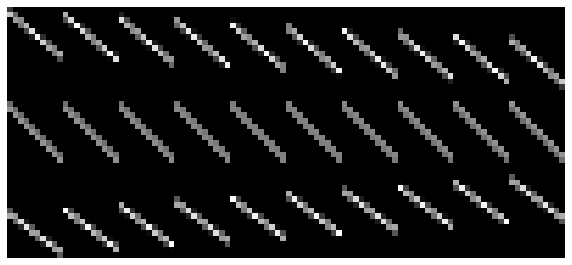

In [380]:
plt.figure(figsize = (10,7))
plt.gray()
plt.imshow(X)
plt.axis('off')
plt.show()

The figure is very close to the figure on exercise sheet, the constructed X can be used in the following experiments.

## Recovering the image

In [76]:
os.chdir('/Users/jocelyn/Desktop/fundamentals of ML/Exercise5')

### 1_The smaller data experiment

In [77]:
alphas_77 = np.load('hs_tomography/alphas_77.npy')
Y_77 = np.load('hs_tomography/y_77.npy')

In [381]:
# X_77 = np.load('hs_tomography/X_77.npy', allow_pickle=True)

X_77 = construct_X(77, alphas_77).todense()

In [382]:
beta = lsqr(X_77, Y_77,atol = 1e-5, btol = 1e-5)[0]

In [383]:
beta1 = beta.reshape([77,77])

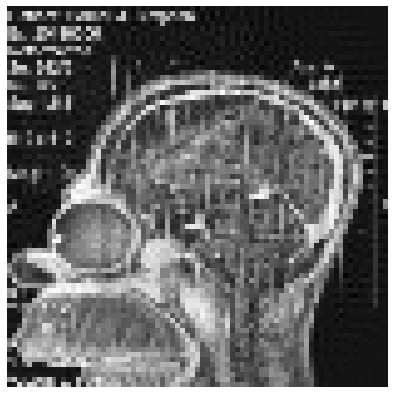

In [384]:
plt.figure(figsize = (7,7))
plt.gray()
plt.imshow(beta1)
plt.axis('off')
plt.show()

### 2_The bigger data experiment

In [267]:
alphas_195 = np.load('hs_tomography/alphas_195.npy')
Y_195 = np.load('hs_tomography/y_195.npy')

In [274]:
X_195 = construct_X(195, alphas_195, 275).todense()

In [347]:
X_195.shape

(49225, 38025)

In [275]:
#Takes too long to run the code
beta2 = lsqr(X_195, Y_195,atol = 1e-5, btol = 1e-5)[0]

KeyboardInterrupt: 

In [ ]:
beta2 = beta.reshape([195,195])

In [ ]:
plt.figure(figsize = (7,7))
plt.gray()
plt.imshow(beta2)
plt.axis('off')
plt.show()


## Minimizing the radiation dose

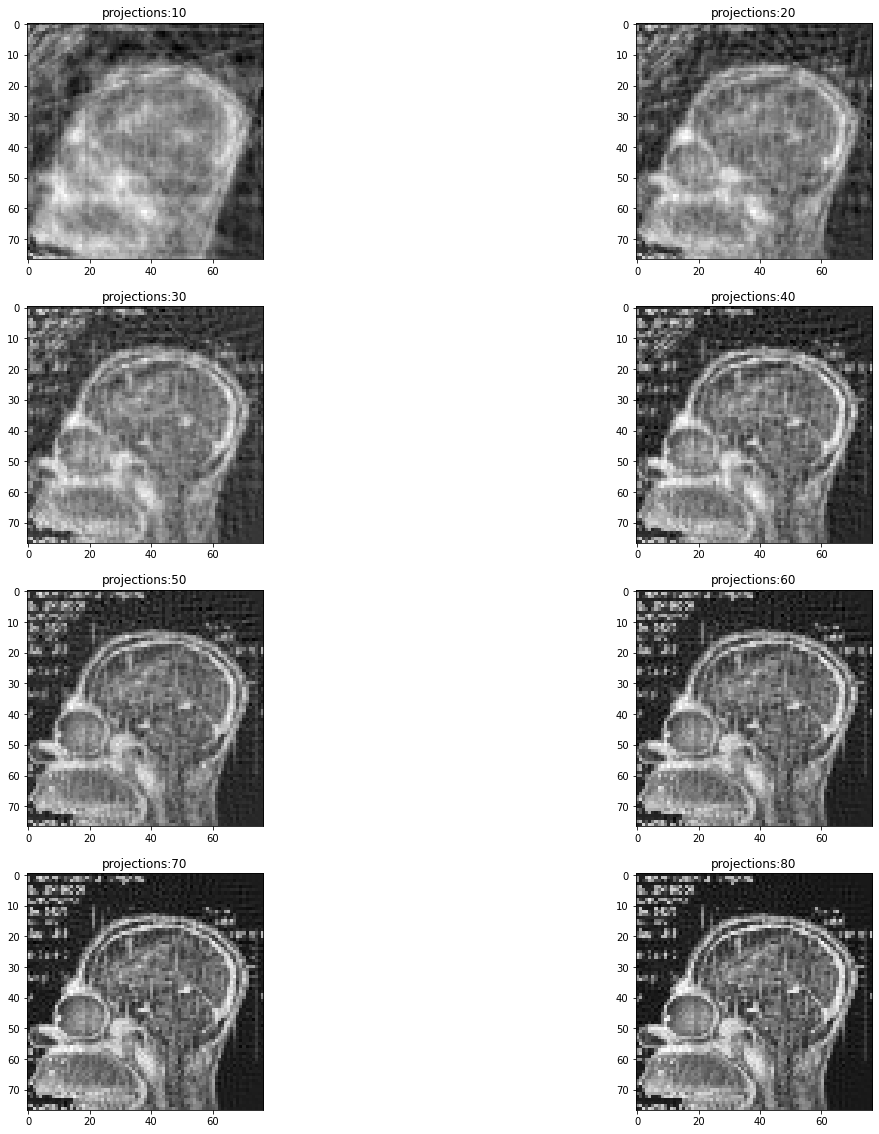

In [386]:
#use 77 smaller data to test
Np = 109 #set sensor size 109
projection = [10,20,30,40,50,60,70,80] 
plt.subplots(4,2, figsize = (20,20))
plt.gray()
plt.axis("off")
for i in range(len(projection)):
    step = len(alphas_77)/projection[i]  #evenly select the indices according the step
    index = [int((step-1) + j *step) for j in range(projection[i])]
    alphas_new = alphas_77[index]
    Y_new = np.array([Y_77[Np*m : Np*(m+1)] for m in index]).flatten()
    
    X = construct_X(77,alphas_new).todense()
    beta = lsqr(X,Y_new,atol = 1e-5, btol = 1e-5)[0].reshape(77,77)
    
    plt.subplot(4,2,i+1)
    plt.imshow(beta)
    plt.title("projections:{}".format(projection[i]))

plt.show()
         

In the case of smaller data experiment, projections less than 50 are very blurry. when projections are bigger than 50, we can gradually see that there's something in the patient H.S. head, which may cause his headache. So the minimal number of projections could be 50 in this case. But if we use the bigger data experiment with bigger M(tomogram pixel) and Np(sensor bins), we could get a smaller minimal number of projections.